In [29]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score as kappa
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 300

<Figure size 2400x1800 with 0 Axes>

In [2]:
label_map = {
    'tumor': {0: 'No tumor', 1: 'Enhancing tumor', 2:'Non-enhancing tumor'},
    'iq': {1: 'non-diagnostic', 2: 'poor', 3: 'diagnostic', 4: 'good', 5: 'excellent'},
    'qc': {1: 'Severe:data unusable', 2: 'Moderate:data unusable', 
           3: 'Moderate:data usable', 4:'Mild', 5: 'None'}
}
def cell_fn(cell_val):
    return pd.Series([v.split('-')[0] for v in cell_val])

def majority_consensus(scores):
    maj_cnt = 0
    for a, b in scores:
        if a == b: maj_cnt += 1
    return (maj_cnt >=2)

def conf_matrix(score_dict, score_key, reader_id):
    y_true = [d[score_key][reader_id][0] for d in score_dict]
#     y_true = [label_map[score_key][x] for x in y_true]
    
    y_pred = [d[score_key][reader_id][1] for d in score_dict]
#     y_pred = [label_map[score_key][x] for x in y_pred]
    
    labels = [1, 2, 3, 4, 5] if score_key != 'tumor' else [0, 1, 2]
    return confusion_matrix(y_true, y_pred), labels#, list(label_map[score_key].values())        

def get_kappa(score_dict, score_key, reader1, reader2, gt=False):
    idx = 0 if gt else 1
    y1 = [d[score_key][reader1][idx] for d in score_dict]
    y2 = [d[score_key][reader2][idx] for d in score_dict]
    return kappa(y1, y2)

drop_col_ids = np.arange(5, 32)

scores_ramin = pd.read_csv('/home/srivathsa/projects/studies/gad/reader_study/mrm_reader1.csv')
scores_ramin.drop(scores_ramin.columns[drop_col_ids], axis=1, inplace=True)
scores_ramin = scores_ramin.apply(cell_fn, axis=1)
scores_ramin.columns = ['case', 'tumor_cateogry', 'iq_score', 'qc_score', 'vessel']

scores_greg = pd.read_csv('/home/srivathsa/projects/studies/gad/reader_study/mrm_reader2.csv')
scores_greg.drop(scores_greg.columns[drop_col_ids], axis=1, inplace=True)
scores_greg = scores_greg.apply(cell_fn, axis=1)
scores_greg.columns = ['case', 'tumor_cateogry', 'iq_score', 'qc_score', 'vessel']

scores_max = pd.read_csv('/home/srivathsa/projects/studies/gad/reader_study/mrm_reader3.csv')
scores_max.drop(scores_max.columns[drop_col_ids], axis=1, inplace=True)
scores_max = scores_max.apply(cell_fn, axis=1)
scores_max.columns = ['case', 'tumor_cateogry', 'iq_score', 'qc_score', 'vessel']

,case,tumor_cateogry,iq_score,qc_score,vessel
0,Case0001,1,5,5,5
1,Case0002,0,3,4,3
2,Case0003,1,5,5,5
3,Case0004,0,3,4,3
4,Case0005,2,4,4,4
...,...,...,...,...,...
95,Case0096,1,3,3,2
96,Case0097,2,5,5,5
97,Case0098,1,4,4,3
98,Case0099,1,5,5,5


In [3]:
dict_cmap = json.loads(open('/home/srivathsa/projects/studies/gad/reader_study/case_map.json', 'r').read())

In [4]:
case_pairs = []

for case_dict in dict_cmap:
    if 'SubtleGad' in case_dict['Patient ID']:
        continue
    pair_obj = {
        'patient_id': case_dict['Patient ID'],
        'gt_case': case_dict['Case Number']
    }
    
    gad_obj = [
        d for d in dict_cmap 
        if 'SubtleGad' in d['Patient ID'] and d['Patient ID'].replace('SubtleGad:', '') == case_dict['Patient ID']
    ][0]
    pair_obj['gad_case'] = gad_obj['Case Number']
    case_pairs.append(pair_obj)

In [ ]:
df_ref = scores_max

for pair_dict in case_pairs:
    gt_row = df_ref.loc[df_ref['case'] == pair_dict['gt_case']].values[0]
    gt_tumor_class = int(gt_row[1])
    
    gad_row = df_ref.loc[df_ref['case'] == pair_dict['gad_case']].values[0]
    gad_tumor_class = int(gad_row[1])
    
    if gt_tumor_class != gad_tumor_class:
        print(pair_dict)
        print(gt_tumor_class, gad_tumor_class)
    
    

In [ ]:
df_ref = scores_max
miscount = 0

for pair_dict in case_pairs:
    gt_row = df_ref.loc[df_ref['case'] == pair_dict['gt_case']].values[0]
    gt_vess = int(gt_row[4])
    
    gad_row = df_ref.loc[df_ref['case'] == pair_dict['gad_case']].values[0]
    gad_vess = int(gad_row[4])
    
    if gt_vess != gad_vess:
        print(gt_vess, gad_vess, pair_dict)
    
    a = int(gad_row[2])
    b = int(gad_row[4])
    if a == b or abs(a-b) ==1:
        miscount += 1

In [ ]:
df_ref = scores_greg
eq_count = 0
grt_count = 0
less_count = 0

dict_iq = {}

for pair_dict in case_pairs:
    gt_row = df_ref.loc[df_ref['case'] == pair_dict['gt_case']].values[0]
    gt_iq = int(gt_row[2])
    
    gad_row = df_ref.loc[df_ref['case'] == pair_dict['gad_case']].values[0]
    gad_iq = int(gad_row[2])
    
    if gt_iq == gad_iq:
        eq_count += 1
    if gad_iq > gt_iq:
        grt_count += 1
    if gad_iq < gt_iq:
#         print(gad_iq, gt_iq)
        less_count += 1
    
    if gad_iq in dict_iq:
        dict_iq[gad_iq] += 1
    else:
        dict_iq[gad_iq] = 1

In [ ]:
dict_iq

In [ ]:
uniq_cases = []
for index, row in scores_ramin.iterrows():
    tumor_score = int(row.values[1])
    greg_row = scores_greg.loc[scores_greg['case'] == row.values[0]].values[0]
    tumor_score_greg = int(greg_row[1])
    case = [d for d in dict_cmap if d['Case Number'] == row.values[0]][0]
    if tumor_score == tumor_score_greg and tumor_score == 1:
#         print(row.values[0], case['Patient ID'])
        uniq_cases.append(case['Patient ID'].replace('SubtleGad:', ''))
# sorted(set(uniq_cases))

In [ ]:
cases = ['NO108','NO113','NO120','NO129','NO18','NO26','NO54','NO56','NO6','NO67','NO71',
         'NO79','Patient_0087','Patient_0090','Patient_0134','Patient_0172','Patient_0173',
         'Patient_0255','Patient_0333','Patient_0342','Patient_0353','Patient_0408','Patient_0486',
         'Patient_0526','Patient_0535','Prisma3','Prisma4','Prisma6','Prisma9']

for case in cases:
    case_rows = [d for d in dict_cmap if case in d['Patient ID']]
    gad_case = case_rows[0] if 'SubtleGad:' in case_rows[0]['Patient ID'] else case_rows[1]
    gt_case = case_rows[1] if 'SubtleGad:' in case_rows[0]['Patient ID'] else case_rows[0]
    
    greg_gt_score = scores_greg[scores_greg['case'] == gt_case['Case Number']].values[0][1]
    greg_gad_score = scores_greg[scores_greg['case'] == gad_case['Case Number']].values[0][1]
    
    ramin_gt_score = scores_ramin[scores_ramin['case'] == gt_case['Case Number']].values[0][1]
    ramin_gad_score = scores_ramin[scores_ramin['case'] == gad_case['Case Number']].values[0][1]
    
    print('{},{},{},{},{}'.format(case, greg_gt_score, ramin_gt_score, greg_gad_score, ramin_gad_score))

In [5]:
compiled_scores = []
for case_row in case_pairs:
    r1_gt = scores_ramin.loc[scores_ramin['case'] == case_row['gt_case']].values[0]
    r1_gad = scores_ramin.loc[scores_ramin['case'] == case_row['gad_case']].values[0]
    
    r2_gt = scores_greg.loc[scores_greg['case'] == case_row['gt_case']].values[0]
    r2_gad = scores_greg.loc[scores_greg['case'] == case_row['gad_case']].values[0]
    
    r3_gt = scores_max.loc[scores_max['case'] == case_row['gt_case']].values[0]
    r3_gad = scores_max.loc[scores_max['case'] == case_row['gad_case']].values[0]
    
    score_obj = {
        'patient_id': case_row['patient_id'],
        'tumor': [
            [int(r1_gt[1]), int(r1_gad[1])],
            [int(r2_gt[1]), int(r2_gad[1])],
            [int(r3_gt[1]), int(r3_gad[1])]
        ],
        'iq': [
            [int(r1_gt[2]), int(r1_gad[2])],
            [int(r2_gt[2]), int(r2_gad[2])],
            [int(r3_gt[2]), int(r3_gad[2])]
        ],
        'qc': [
            [int(r1_gt[3]), int(r1_gad[3])],
            [int(r2_gt[3]), int(r2_gad[3])],
            [int(r3_gt[3]), int(r3_gad[3])]
        ]
        
    }
    
    compiled_scores.append(score_obj)

In [26]:
compiled_scores

[{'patient_id': '101_Id_051',
  'tumor': [[0, 0], [0, 0], [0, 0]],
  'iq': [[3, 4], [4, 5], [5, 5]],
  'qc': [[4, 5], [5, 5], [5, 5]]},
 {'patient_id': 'Patient_0157',
  'tumor': [[2, 2], [2, 2], [2, 2]],
  'iq': [[4, 4], [4, 3], [4, 2]],
  'qc': [[4, 4], [5, 3], [4, 2]]},
 {'patient_id': 'Patient_0286',
  'tumor': [[2, 2], [1, 1], [2, 2]],
  'iq': [[3, 2], [2, 2], [3, 2]],
  'qc': [[3, 3], [2, 2], [3, 2]]},
 {'patient_id': 'NO56',
  'tumor': [[1, 1], [1, 1], [1, 1]],
  'iq': [[5, 5], [4, 3], [4, 3]],
  'qc': [[4, 5], [5, 5], [5, 5]]},
 {'patient_id': 'Prisma3',
  'tumor': [[1, 2], [1, 2], [1, 1]],
  'iq': [[4, 5], [5, 5], [4, 5]],
  'qc': [[4, 5], [5, 5], [5, 5]]},
 {'patient_id': 'NO79',
  'tumor': [[1, 1], [1, 1], [1, 1]],
  'iq': [[3, 3], [4, 4], [4, 4]],
  'qc': [[3, 3], [4, 4], [5, 4]]},
 {'patient_id': '101_Id_066',
  'tumor': [[0, 0], [0, 0], [0, 0]],
  'iq': [[4, 5], [5, 4], [5, 4]],
  'qc': [[4, 5], [5, 5], [5, 4]]},
 {'patient_id': 'Patient_0486',
  'tumor': [[1, 1], [1, 1],

In [85]:
print(round(get_kappa(compiled_scores, 'tumor', 0, 1), 3))
print(get_kappa(compiled_scores, 'tumor', 1, 2))
print(get_kappa(compiled_scores, 'tumor', 0, 2))
print('---')
print(get_kappa(compiled_scores, 'tumor', 0, 1, gt=True))
print(get_kappa(compiled_scores, 'tumor', 1, 2, gt=True))
print(get_kappa(compiled_scores, 'tumor', 0, 2, gt=True))

0.605
0.6715927750410509
0.6674057649667405
---
0.7054491899852724
0.7852233676975945
0.6676514032496307


In [6]:
for score_row in compiled_scores:
    if not majority_consensus(score_row['tumor']):
        print(score_row)

{'patient_id': 'Prisma3', 'tumor': [[1, 2], [1, 2], [1, 1]], 'iq': [[4, 5], [5, 5], [4, 5]], 'qc': [[4, 5], [5, 5], [5, 5]]}


In [ ]:
t_a = 0.0
t_b = 0.0
for score_row in compiled_scores:
    iq_a, iq_b = score_row['qc'][2]
    t_a += iq_a
    t_b += iq_b
print(t_a / 50.0)
print(t_b / 50.0)

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5')]

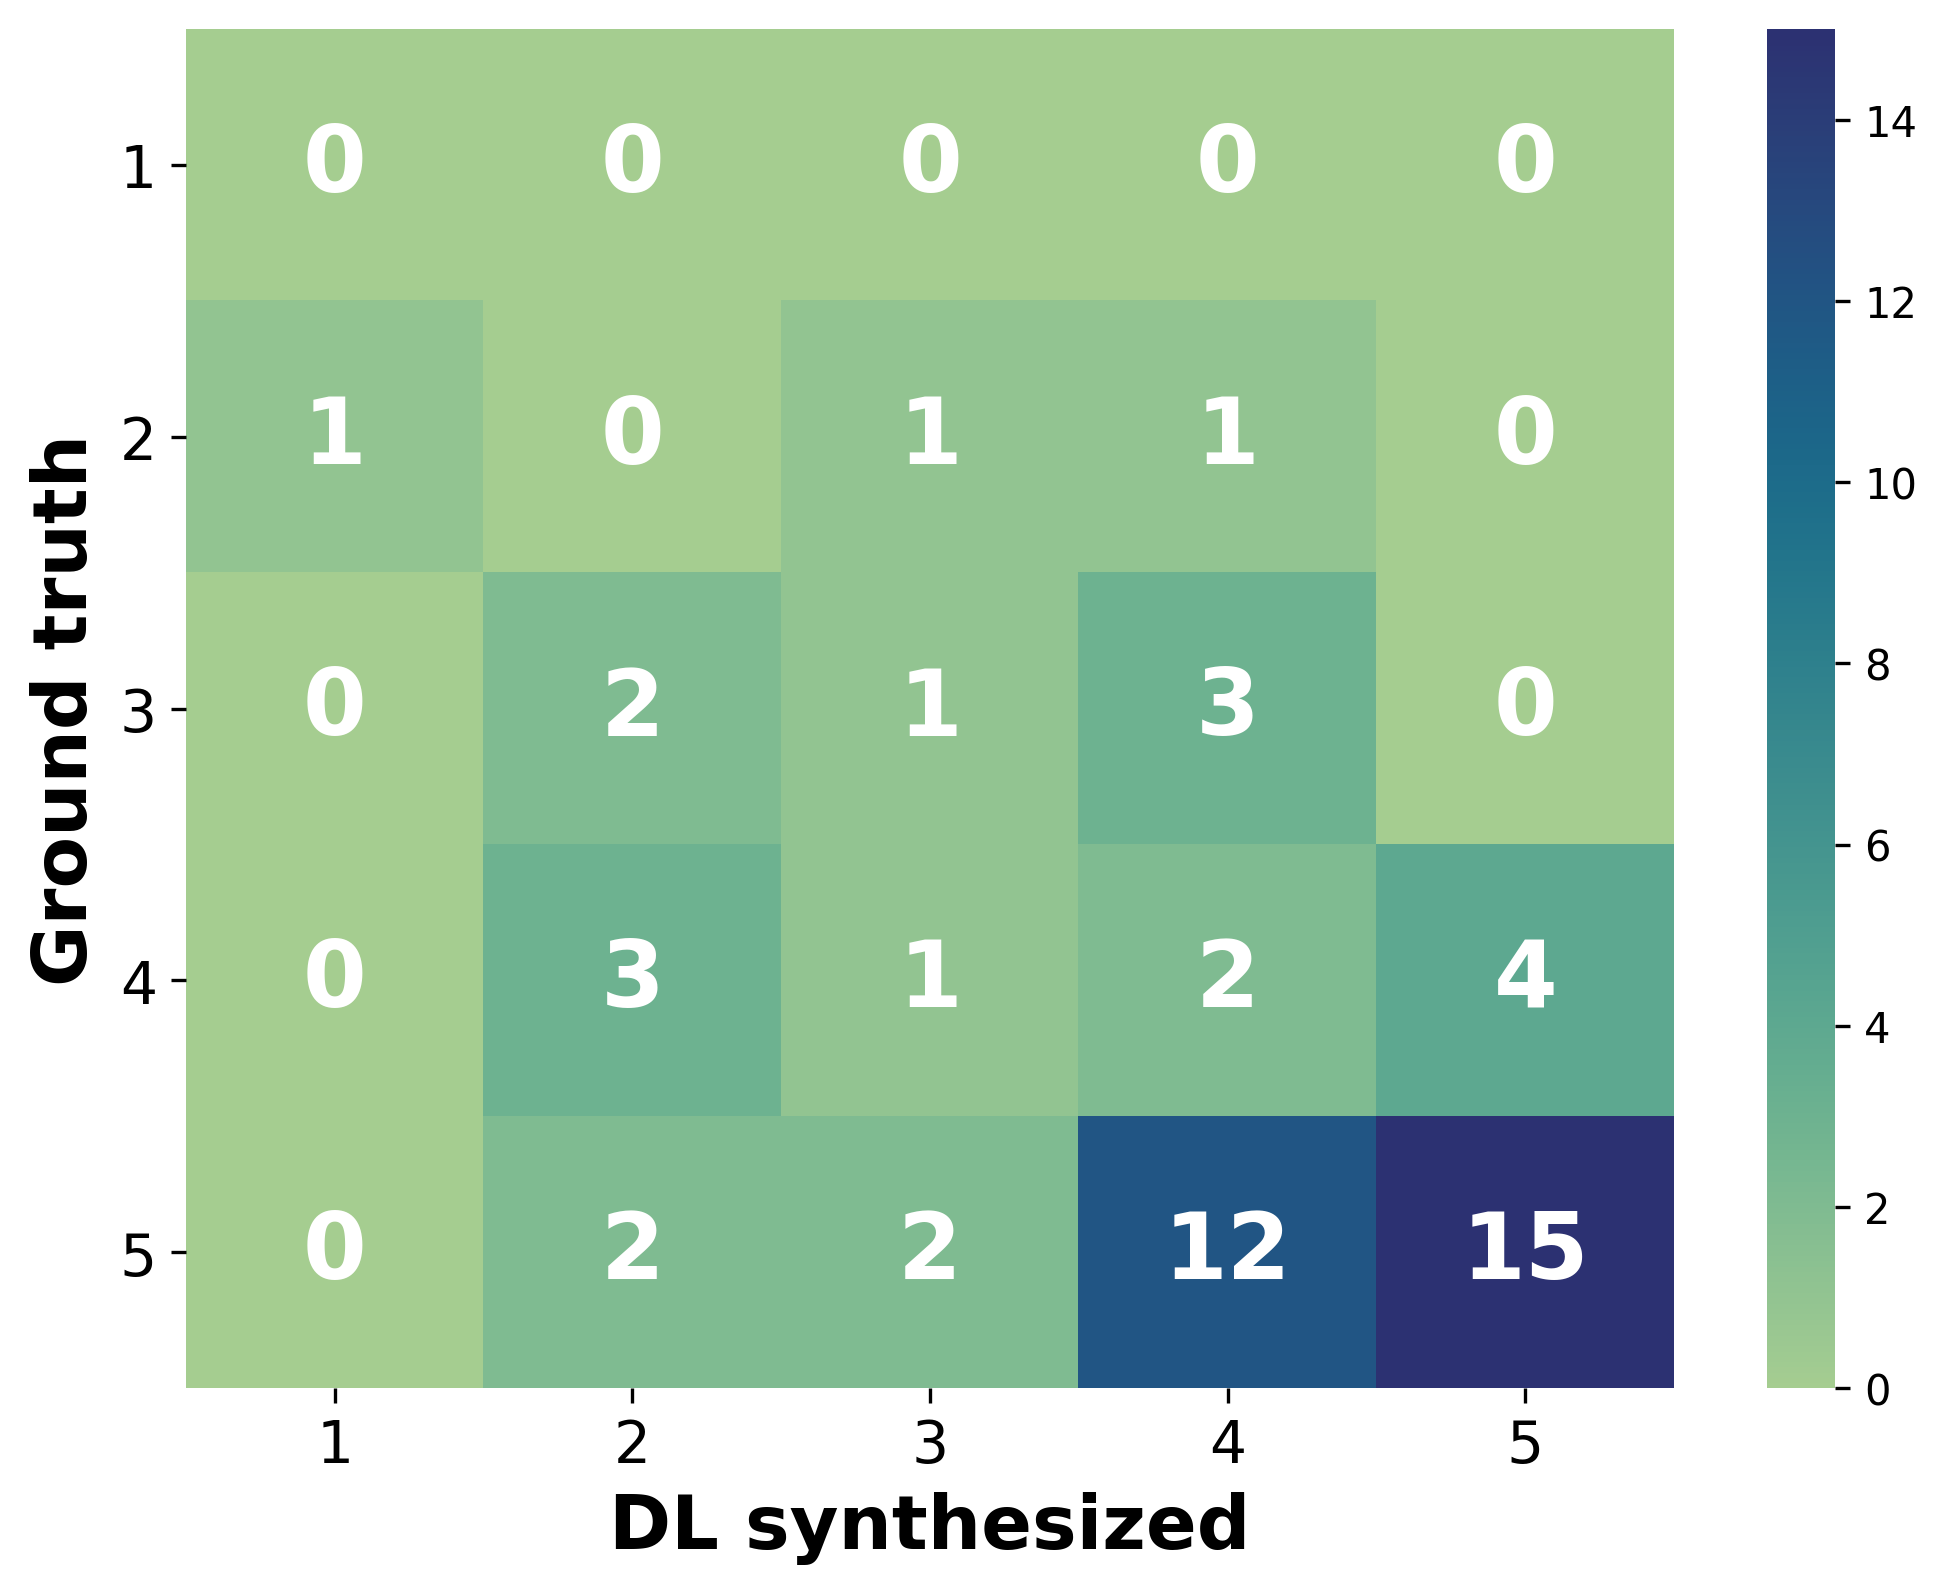

In [100]:
cm, labels = conf_matrix(compiled_scores, 'qc', 2)
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
ax= plt.subplot()
hmap = sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="crest", annot_kws={"size":22, "weight": "bold", "color": "white"})

ax.set_xlabel('DL synthesized', fontsize=18, weight='bold')
ax.set_ylabel('Ground truth', fontsize=18, weight='bold')
hmap.set_xticklabels(labels, rotation=0, fontsize=14)
hmap.set_yticklabels(labels, rotation=0, fontsize=14)

In [60]:
name_map = {
    'gt': 'Ground Truth',
    'gad': 'DL Synthesized',
    'tumor': 'Tumor Category',
    'iq': 'Overall Image Quality',
    'qc': 'Artifact Score'
}
flat_dicts = []
readers = ['A', 'B', 'C']
types = ['gt', 'gad']
criteria = ['tumor', 'iq', 'qc']
for row in compiled_scores:
    for r, reader in enumerate(readers):
        for c, cr in enumerate(criteria):
            for t, tpe in enumerate(types):
                flat_obj = {
                    'case': row['patient_id'],
                    'reader': reader,
                    'criteria': name_map[cr],
                    'type': name_map[tpe]
                }
                flat_obj['score'] = row[cr][r][t]
                flat_dicts.append(flat_obj)
            
df_scores = pd.DataFrame(flat_dicts)

In [61]:
df_scores

,case,reader,criteria,type,score
0,101_Id_051,A,Tumor Category,Ground Truth,0
1,101_Id_051,A,Tumor Category,DL Synthesized,0
2,101_Id_051,A,Overall Image Quality,Ground Truth,3
3,101_Id_051,A,Overall Image Quality,DL Synthesized,4
4,101_Id_051,A,Artifact Score,Ground Truth,4
...,...,...,...,...,...
895,Patient_0575,C,Tumor Category,DL Synthesized,0
896,Patient_0575,C,Overall Image Quality,Ground Truth,5
897,Patient_0575,C,Overall Image Quality,DL Synthesized,5
898,Patient_0575,C,Artifact Score,Ground Truth,5


Text(0, 0.5, 'Mean scores (n = 3 readers)')

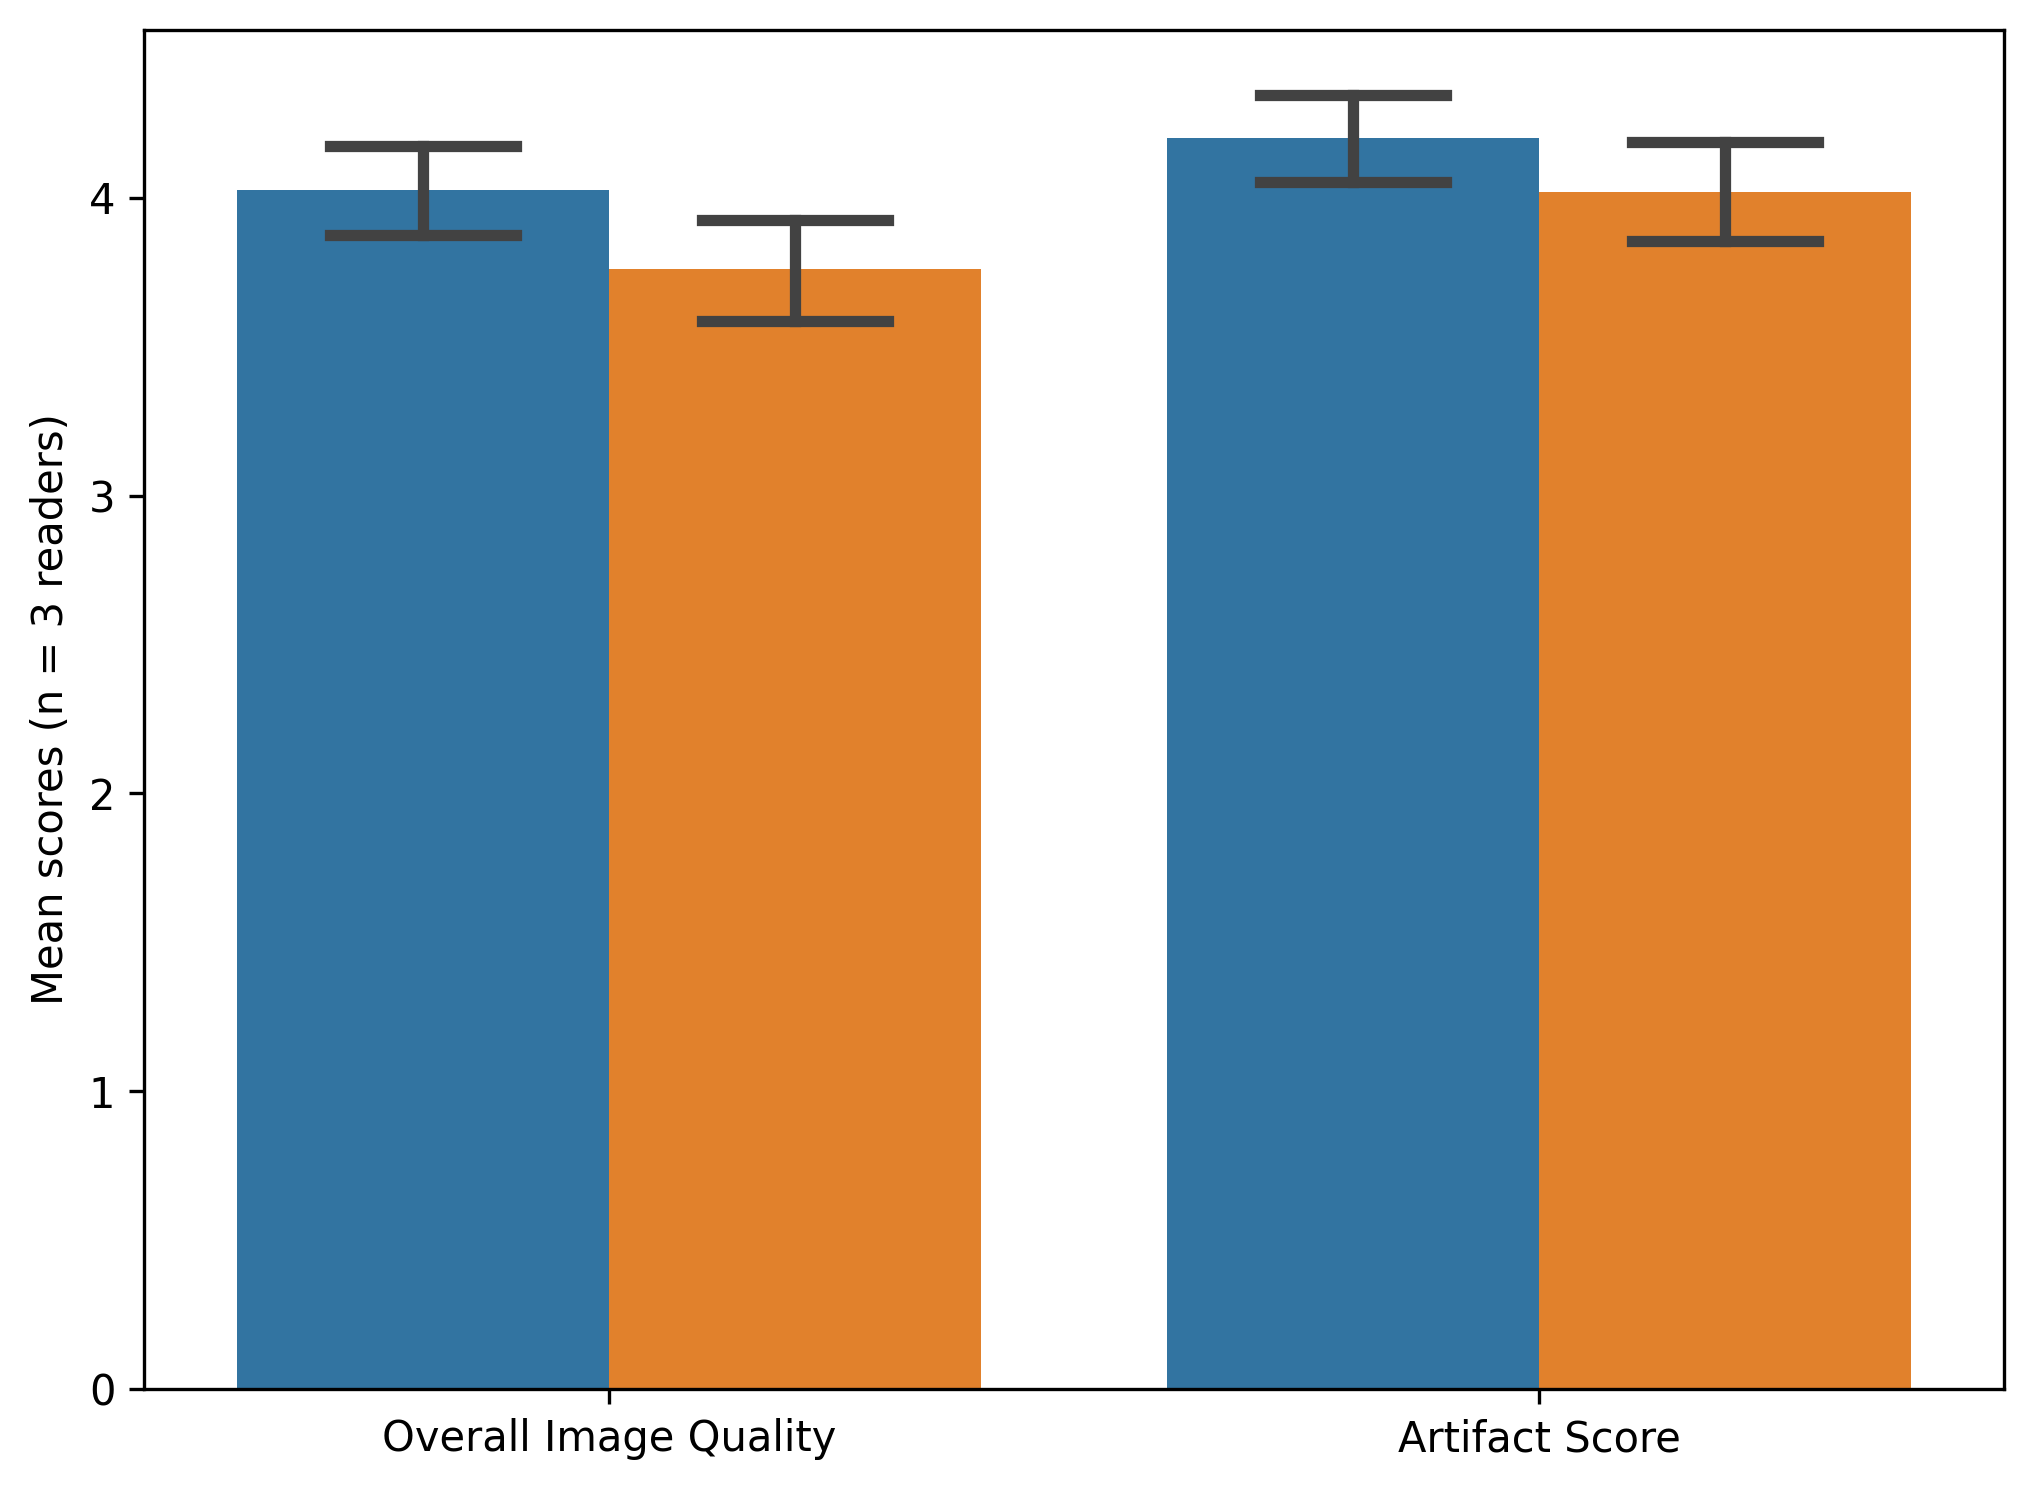

In [89]:
ax = sns.barplot(x="criteria", y="score", hue="type", 
                 data=df_scores.loc[df_scores['criteria'] != 'Tumor Category'], 
                 capsize=0.2)
leg = ax.get_legend()
leg.remove()
ax.set_xlabel('')
ax.set_ylabel('Mean scores (n = 3 readers)')

In [76]:
x = [np.array(d['tumor'])[i, 0] for i in np.arange(3) for d in compiled_scores]
y = [np.array(d['tumor'])[i, 1] for i in np.arange(3) for d in compiled_scores]
print(scipy.stats.wilcoxon(x, y))

WilcoxonResult(statistic=7.0, pvalue=0.2059032107320684)


/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [77]:
x = [np.array(d['iq'])[i, 0] for i in np.arange(3) for d in compiled_scores]
y = [np.array(d['iq'])[i, 1] for i in np.arange(3) for d in compiled_scores]
print(scipy.stats.wilcoxon(x, y))

WilcoxonResult(statistic=1088.0, pvalue=0.00162567258503523)


In [78]:
x = [np.array(d['qc'])[i, 0] for i in np.arange(3) for d in compiled_scores]
y = [np.array(d['qc'])[i, 1] for i in np.arange(3) for d in compiled_scores]
print(scipy.stats.wilcoxon(x, y))

WilcoxonResult(statistic=1232.0, pvalue=0.033212929539098296)


In [104]:
for d in compiled_scores:
    print(d['patient_id'])


101_Id_051
Patient_0157
Patient_0286
NO56
Prisma3
NO79
101_Id_066
Patient_0486
NO113
Patient_0178
NO67
Id0032
Patient_0090
Prisma4
Patient_0276
Prisma6
NO130
NO62
Prisma1
Patient_0408
Patient_0353
Prisma9
Prisma22
NO120
NO18
Patient_0400
Patient_0172
Patient_0333
Patient_0087
Patient_0535
Patient_0375
Patient_0342
NO71
NO129
Patient_0526
Patient_0134
NO55
NO60
NO54
Patient_0269
Patient_0556
Patient_0538
Patient_0173
Patient_0255
Prisma21
NO108
Prisma23
NO26
NO6
Patient_0575
